In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# use GPU for computations if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
class Net(nn.Module):
    #Define vectors and matrices of the network
    def __init__(self):
        super(Net, self).__init__()
        U1=24
        U2 = 12
        U3 = 6
        
        self.W1 = nn.Parameter(0.1*torch.randn(14, U1))
        self.b1 = nn.Parameter(torch.zeros(U1))
        
        self.W2 = nn.Parameter(0.1*torch.randn(U1,U2))
        self.b2 = nn.Parameter(torch.zeros(U2))

        self.W3 = nn.Parameter(0.1*torch.randn(U2,U3))
        self.b3 = nn.Parameter(torch.zeros(U3))
        
    
    def forward(self, X):
        #Define nodes in hidden layer
        # flatten the data into a matrix with 28 x 28 = 784 columns
        #X = X.view(-1, 1)
        
        Q1 = torch.sigmoid(X.mm(self.W1)+self.b1)
        Q2 = torch.sigmoid(Q1.mm(self.W2)+self.b2)
        # compute the linear transformation
        #Z = X.mm(self.W) + self.b
        # apply the softmax function
        G = F.softmax(Q2.mm(self.W3)+self.b3, dim=1)
        return G
    
def crossentropy(G, Y):
    # convert labels to onehot encoding
    Y_onehot = Y
    return -(Y_onehot * G.log()).sum(dim = 1).mean()

def accuracy(G, Y):
    return (torch.max(G,1)[1]==torch.max(Y,1)[1]).float().mean()

In [4]:

dataa = pd.read_csv('epinfo.csv')
features = ['Number of lines','Number of words','Different words used','Different words used', 'Words per line'\
           ,'Different words ratio', 'Exclamation marks','Question marks','Most common Monica','Most common Rachel'\
           ,'Most common Chandler','Most common Ross','Most common Joey','Most common Phoebe']#most common...


#dataa[features]
X = dataa[features]
Y = dataa['Character']


apa = np.identity(6)
nyY = []
for i in Y:
    if i=='Rachel':
        i=nyY.append(apa[0])
    elif i=='Phoebe':
        i=nyY.append(apa[1])
    elif i=='Monica':
        i=nyY.append(apa[2])
    elif i=='Chandler':
        i=nyY.append(apa[3])
    elif i=='Joey':
        i=nyY.append(apa[4])
    elif i=='Ross':
        i=nyY.append(apa[5])

X_torch = torch.tensor(X.values).float()
Y_torch=torch.FloatTensor(nyY)
X_train = X_torch[:1200]
Y_train = Y_torch[:1200]
X_test = X_torch[1200:]
Y_test = Y_torch[1200:]

Epoch    1: training loss  1.809203
Epoch  100: training loss  1.788237
Epoch  200: training loss  1.786027
Epoch  300: training loss  1.781687
Epoch  400: training loss  1.787349
Epoch  500: training loss  1.776887
Epoch  600: training loss  1.790431
Epoch  700: training loss  1.781749
Epoch  800: training loss  1.775484
Epoch  900: training loss  1.798091
Epoch 1000: training loss  1.780524


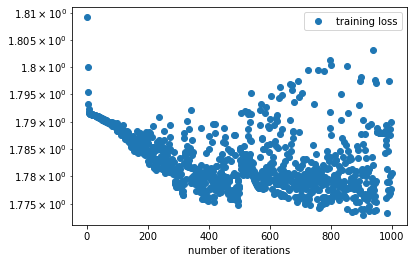

In [7]:
# initialize the neural network and move it to the GPU if needed
net = Net()
net.to(device)

# define the optimization algorithm
learningrate = 0.5
optimizer = optim.SGD(net.parameters(), lr=learningrate)

training_loss = []

for i in range(1000):
    # move batch to the GPU if needed
    X_train, Y_train = X_train.to(device), Y_train.to(device)
    
    optimizer.zero_grad()
    
    train_pred = net(X_train)
    loss = crossentropy(train_pred,Y_train)
    training_loss.append(loss.item())
    if i == 0 or (i + 1) % 100 == 0:
      print(f"Epoch {i + 1:4d}: training loss {training_loss[-1]: 9.6f}")
    
    loss.backward()
    optimizer.step()
    
plt.figure()
plt.plot(np.arange(1, len(training_loss) + 1), training_loss, 'o', label='training loss')
plt.yscale('log')
plt.xlabel('number of iterations')
plt.legend()
plt.show()



In [87]:
# initialize the neural network and move it to the GPU if needed
net = Net()
net.to(device)

# define the optimization algorithm
learningrate = 0.5
optimizer = optim.SGD(net.parameters(), lr=learningrate)

#training_loss = []

test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []

for i in range(200000):
    # move batch to the GPU if needed
    X_train, Y_train = X_train.to(device), Y_train.to(device)
    
    optimizer.zero_grad()
    
    train_pred = net(X_train)
    loss = crossentropy(train_pred,Y_train)
    
    #training_loss.append(loss.item())
    #if i == 0 or (i + 1) % 100 == 0:
    #  print(f"Epoch {i + 1:4d}: training loss {training_loss[-1]: 9.6f}")
    
    loss.backward()
    optimizer.step()

    with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if i % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(train_pred, Y_train).item())
                train_iter.append(i)
                
            # evaluate the performance on the test data at every 100th iteration
            if i % 100 == 0:
                # move test data to the GPU if needed
                X_test, Y_test = X_test.to(device), Y_test.to(device)

                # compute predictions for the test data
                G = net(X_test)
                test_crossentropy.append(crossentropy(G, Y_test).item())
                      
                test_accuracy.append(accuracy(G, Y_test).item())
                test_iter.append(i)

                # print the iteration number and the accuracy of the predictions
                print(f"Step {i:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train cross-entropy {train_crossentropy[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test cross-entropy {test_crossentropy[-1]:5.2f}")
    

Step     0: train accuracy  16.67% train cross-entropy  1.81  test accuracy  16.67% test cross-entropy  1.80
Step   100: train accuracy  16.00% train cross-entropy  1.79  test accuracy  12.07% test cross-entropy  1.79
Step   200: train accuracy  17.92% train cross-entropy  1.79  test accuracy  21.26% test cross-entropy  1.79
Step   300: train accuracy  19.25% train cross-entropy  1.79  test accuracy  18.97% test cross-entropy  1.79
Step   400: train accuracy  19.83% train cross-entropy  1.79  test accuracy  18.39% test cross-entropy  1.79
Step   500: train accuracy  18.83% train cross-entropy  1.79  test accuracy  21.84% test cross-entropy  1.78
Step   600: train accuracy  20.83% train cross-entropy  1.78  test accuracy  18.97% test cross-entropy  1.79
Step   700: train accuracy  19.33% train cross-entropy  1.78  test accuracy  21.26% test cross-entropy  1.78
Step   800: train accuracy  20.33% train cross-entropy  1.78  test accuracy  21.26% test cross-entropy  1.78
Step   900: train a

Step 15100: train accuracy  21.92% train cross-entropy  1.77  test accuracy  20.11% test cross-entropy  1.77
Step 15200: train accuracy  22.75% train cross-entropy  1.76  test accuracy  18.39% test cross-entropy  1.80
Step 15300: train accuracy  23.00% train cross-entropy  1.76  test accuracy  18.39% test cross-entropy  1.78
Step 15400: train accuracy  22.67% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 15500: train accuracy  20.83% train cross-entropy  1.77  test accuracy  22.41% test cross-entropy  1.77
Step 15600: train accuracy  22.00% train cross-entropy  1.77  test accuracy  21.26% test cross-entropy  1.78
Step 15700: train accuracy  22.25% train cross-entropy  1.77  test accuracy  19.54% test cross-entropy  1.79
Step 15800: train accuracy  22.25% train cross-entropy  1.77  test accuracy  21.84% test cross-entropy  1.77
Step 15900: train accuracy  22.08% train cross-entropy  1.77  test accuracy  18.39% test cross-entropy  1.78
Step 16000: train a

Step 22700: train accuracy  22.50% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.77
Step 22800: train accuracy  23.25% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.78
Step 22900: train accuracy  22.08% train cross-entropy  1.77  test accuracy  20.69% test cross-entropy  1.78
Step 23000: train accuracy  22.50% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.77
Step 23100: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 23200: train accuracy  22.50% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.76
Step 23300: train accuracy  22.33% train cross-entropy  1.77  test accuracy  21.26% test cross-entropy  1.78
Step 23400: train accuracy  22.50% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.78
Step 23500: train accuracy  22.33% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.77
Step 23600: train a

Step 37800: train accuracy  22.58% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.76
Step 37900: train accuracy  22.50% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.78
Step 38000: train accuracy  22.67% train cross-entropy  1.76  test accuracy  20.69% test cross-entropy  1.78
Step 38100: train accuracy  22.08% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.78
Step 38200: train accuracy  22.75% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.78
Step 38300: train accuracy  22.50% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.78
Step 38400: train accuracy  22.50% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 38500: train accuracy  22.08% train cross-entropy  1.76  test accuracy  21.84% test cross-entropy  1.76
Step 38600: train accuracy  22.33% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.78
Step 38700: train a

Step 52800: train accuracy  22.33% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 52900: train accuracy  22.75% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 53000: train accuracy  22.58% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.76
Step 53100: train accuracy  22.50% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 53200: train accuracy  22.08% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 53300: train accuracy  22.33% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 53400: train accuracy  22.50% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 53500: train accuracy  22.25% train cross-entropy  1.76  test accuracy  21.84% test cross-entropy  1.76
Step 53600: train accuracy  21.92% train cross-entropy  1.77  test accuracy  20.11% test cross-entropy  1.77
Step 53700: train a

Step 60400: train accuracy  22.33% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 60500: train accuracy  22.33% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 60600: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 60700: train accuracy  21.17% train cross-entropy  1.77  test accuracy  18.97% test cross-entropy  1.78
Step 60800: train accuracy  22.33% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 60900: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 61000: train accuracy  22.50% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 61100: train accuracy  22.17% train cross-entropy  1.76  test accuracy  20.69% test cross-entropy  1.77
Step 61200: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 61300: train a

Step 68000: train accuracy  21.83% train cross-entropy  1.77  test accuracy  18.97% test cross-entropy  1.78
Step 68100: train accuracy  22.00% train cross-entropy  1.77  test accuracy  20.11% test cross-entropy  1.77
Step 68200: train accuracy  22.42% train cross-entropy  1.76  test accuracy  21.84% test cross-entropy  1.76
Step 68300: train accuracy  22.42% train cross-entropy  1.76  test accuracy  21.84% test cross-entropy  1.76
Step 68400: train accuracy  22.08% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.76
Step 68500: train accuracy  22.50% train cross-entropy  1.76  test accuracy  21.84% test cross-entropy  1.76
Step 68600: train accuracy  22.42% train cross-entropy  1.76  test accuracy  21.84% test cross-entropy  1.76
Step 68700: train accuracy  22.42% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 68800: train accuracy  22.58% train cross-entropy  1.76  test accuracy  21.84% test cross-entropy  1.76
Step 68900: train a

Step 75600: train accuracy  22.42% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.76
Step 75700: train accuracy  22.17% train cross-entropy  1.77  test accuracy  18.97% test cross-entropy  1.78
Step 75800: train accuracy  21.92% train cross-entropy  1.77  test accuracy  20.11% test cross-entropy  1.77
Step 75900: train accuracy  22.42% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 76000: train accuracy  22.42% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 76100: train accuracy  22.42% train cross-entropy  1.76  test accuracy  21.84% test cross-entropy  1.76
Step 76200: train accuracy  22.08% train cross-entropy  1.77  test accuracy  21.84% test cross-entropy  1.76
Step 76300: train accuracy  22.50% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 76400: train accuracy  22.67% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 76500: train a

Step 90800: train accuracy  22.50% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 90900: train accuracy  22.50% train cross-entropy  1.76  test accuracy  21.84% test cross-entropy  1.76
Step 91000: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 91100: train accuracy  22.42% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.77
Step 91200: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 91300: train accuracy  22.33% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 91400: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 91500: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 91600: train accuracy  22.08% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 91700: train a

Step 98500: train accuracy  22.50% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 98600: train accuracy  22.75% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 98700: train accuracy  22.33% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 98800: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 98900: train accuracy  22.42% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 99000: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 99100: train accuracy  22.17% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 99200: train accuracy  22.42% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 99300: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 99400: train a

Step 106000: train accuracy  22.67% train cross-entropy  1.76  test accuracy  21.26% test cross-entropy  1.76
Step 106100: train accuracy  22.33% train cross-entropy  1.77  test accuracy  18.97% test cross-entropy  1.78
Step 106200: train accuracy  22.67% train cross-entropy  1.76  test accuracy  20.69% test cross-entropy  1.76
Step 106300: train accuracy  22.50% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 106400: train accuracy  22.42% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 106500: train accuracy  22.75% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 106600: train accuracy  22.83% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 106700: train accuracy  22.00% train cross-entropy  1.77  test accuracy  18.97% test cross-entropy  1.78
Step 106800: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 10690

Step 120800: train accuracy  22.08% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 120900: train accuracy  22.75% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 121000: train accuracy  22.25% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 121100: train accuracy  22.67% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 121200: train accuracy  22.67% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 121300: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 121400: train accuracy  22.67% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 121500: train accuracy  22.67% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 121600: train accuracy  22.50% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 12170

Step 128300: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 128400: train accuracy  22.83% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 128500: train accuracy  22.50% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 128600: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 128700: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 128800: train accuracy  22.83% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 128900: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 129000: train accuracy  22.58% train cross-entropy  1.76  test accuracy  20.69% test cross-entropy  1.76
Step 129100: train accuracy  22.42% train cross-entropy  1.76  test accuracy  21.84% test cross-entropy  1.76
Step 12920

Step 143100: train accuracy  22.42% train cross-entropy  1.76  test accuracy  21.84% test cross-entropy  1.76
Step 143200: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 143300: train accuracy  22.58% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 143400: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 143500: train accuracy  22.33% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 143600: train accuracy  22.58% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 143700: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 143800: train accuracy  22.42% train cross-entropy  1.76  test accuracy  21.84% test cross-entropy  1.76
Step 143900: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 14400

Step 158000: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 158100: train accuracy  22.50% train cross-entropy  1.76  test accuracy  20.69% test cross-entropy  1.77
Step 158200: train accuracy  22.67% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 158300: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 158400: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 158500: train accuracy  22.42% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 158600: train accuracy  22.50% train cross-entropy  1.76  test accuracy  21.84% test cross-entropy  1.76
Step 158700: train accuracy  22.50% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 158800: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 15890

Step 172900: train accuracy  22.50% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 173000: train accuracy  22.67% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 173100: train accuracy  22.33% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 173200: train accuracy  22.75% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 173300: train accuracy  22.75% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 173400: train accuracy  22.50% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 173500: train accuracy  22.83% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 173600: train accuracy  22.67% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 173700: train accuracy  22.75% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 17380

Step 180400: train accuracy  22.33% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 180500: train accuracy  22.83% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 180600: train accuracy  22.33% train cross-entropy  1.76  test accuracy  20.11% test cross-entropy  1.77
Step 180700: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 180800: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 180900: train accuracy  22.67% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 181000: train accuracy  22.67% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 181100: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 181200: train accuracy  22.42% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 18130

Step 195200: train accuracy  22.67% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 195300: train accuracy  22.75% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 195400: train accuracy  22.83% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 195500: train accuracy  22.58% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 195600: train accuracy  22.58% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 195700: train accuracy  22.58% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 195800: train accuracy  22.50% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.78
Step 195900: train accuracy  22.58% train cross-entropy  1.76  test accuracy  19.54% test cross-entropy  1.77
Step 196000: train accuracy  22.83% train cross-entropy  1.76  test accuracy  18.97% test cross-entropy  1.78
Step 19610

In [76]:
#print(train_pred[1:10])

#pissapa = []
#for i in Y_train:
    
#print(Y_train[1:10])
#print((train_pred.argmax(dim=1) == Y).float().mean())

#train_pred.argmax(dim=1)

(torch.max(train_pred,1)[1]==torch.max(Y_train,1)[1]).float().mean()


tensor(0.2233, device='cuda:0')